In [32]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.optimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

file = 'data.csv'
data = pd.read_csv(file)

Sharpe Ratio

In [22]:
mean_returns = data.mean()
cov_matrix = data.cov()

risk_free_rate = 0.0475

def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    weights = np.array(weights)
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -((portfolio_return - risk_free_rate) / portfolio_std_dev)

num_assets = len(mean_returns)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: x + 1})
bounds = tuple((-1, 1) for _ in range(num_assets))

initial_guess = num_assets * [1. / num_assets]

result = scipy.optimize.minimize(
    fun=sharpe_ratio,
    x0=initial_guess,
    args=(mean_returns, cov_matrix, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = result.x
optimal_sharpe_ratio = -result.fun

optimal_portfolio_return = np.dot(optimal_weights, mean_returns)
optimal_portfolio_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.8f}")
print(f"Optimal Portfolio Return: {optimal_portfolio_return:.8f}")
print(f"Optimal Portfolio Standard Deviation (Volatility): {optimal_portfolio_std_dev:.8f}")

for i, weight in enumerate(optimal_weights, start=1):
    print(f"Weight for Asset {i}: {weight:.8f}")


Optimal Sharpe Ratio: 0.34413588
Optimal Portfolio Return: 0.18205896
Optimal Portfolio Standard Deviation (Volatility): 0.39100532
Weight for Asset 1: 0.15202905
Weight for Asset 2: -0.13302032
Weight for Asset 3: 0.98099127


RRp

In [23]:
def expected_shortfall(returns, weights=None, alpha=0.025):
    if weights is not None:
        portfolio_returns = np.dot(returns, weights)
    else:
        portfolio_returns = returns
    
    sorted_returns = np.sort(portfolio_returns)
    cutoff_index = int(np.ceil(alpha * len(sorted_returns)))
    es_value = -np.mean(sorted_returns[:cutoff_index])
    return es_value

def risk_adjusted_return(weights, mean_returns, data, risk_free_rate, alpha=0.025):
    portfolio_return = np.dot(weights, mean_returns)
    es_value = expected_shortfall(data, weights, alpha=alpha)
    return -(portfolio_return - risk_free_rate) / es_value

result = scipy.optimize.minimize(
    fun=risk_adjusted_return,
    x0=initial_guess,
    args=(mean_returns, data.values, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

rrp_weights = result.x
optimal_risk_adjusted_return = -(result.fun)
rrp_portfolio_return = np.dot(rrp_weights, mean_returns)
rrp_portfolio_volatility = np.sqrt(np.dot(rrp_weights.T, np.dot(cov_matrix, rrp_weights)))

print(f"Optimal Risk-Adjusted Return: {optimal_risk_adjusted_return:.8f}")
print(f"Optimal Portfolio Return: {rrp_portfolio_return:.8f}")
print(f"Optimal Portfolio Volatility: {rrp_portfolio_volatility:.8f}")

for i, weight in enumerate(rrp_weights, start=1):
    print(f"Weight for Asset {i}: {weight:.8f}")


Optimal Risk-Adjusted Return: 0.29460224
Optimal Portfolio Return: 0.16038810
Optimal Portfolio Volatility: 0.41777086
Weight for Asset 1: 0.33005598
Weight for Asset 2: 0.04734918
Weight for Asset 3: 0.62259484


In [24]:
comparison_data = {
    "Metric": [
        "Optimal Portfolio Return",
        "Optimal Portfolio Volatility",
        "Optimal Sharpe Ratio",
        "Optimal Risk-Adjusted Return",
        "Weight for Asset 1",
        "Weight for Asset 2",
        "Weight for Asset 3"
    ],
    "Sharpe Ratio Portfolio": [
        optimal_portfolio_return,
        optimal_portfolio_std_dev,
        optimal_sharpe_ratio,
        None,
        optimal_weights[0],
        optimal_weights[1],
        optimal_weights[2]
    ],
    "Risk-Adjusted Portfolio": [
        rrp_portfolio_return,
        rrp_portfolio_volatility,
        None,
        optimal_risk_adjusted_return,
        rrp_weights[0],
        rrp_weights[1],
        rrp_weights[2]
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Portfolio Optimization Comparison Table")
print(comparison_df)


Portfolio Optimization Comparison Table
                         Metric  Sharpe Ratio Portfolio  \
0      Optimal Portfolio Return                0.182059   
1  Optimal Portfolio Volatility                0.391005   
2          Optimal Sharpe Ratio                0.344136   
3  Optimal Risk-Adjusted Return                     NaN   
4            Weight for Asset 1                0.152029   
5            Weight for Asset 2               -0.133020   
6            Weight for Asset 3                0.980991   

   Risk-Adjusted Portfolio  
0                 0.160388  
1                 0.417771  
2                      NaN  
3                 0.294602  
4                 0.330056  
5                 0.047349  
6                 0.622595  


Explanations

In [25]:
asset_volatilities = data.std()

for i, vol in enumerate(asset_volatilities, start=1):
    print(f"Standard Deviation (Volatility) for Asset {i}: {vol:.8f}")


Standard Deviation (Volatility) for Asset 1: 1.22846120
Standard Deviation (Volatility) for Asset 2: 0.92593495
Standard Deviation (Volatility) for Asset 3: 0.25386977


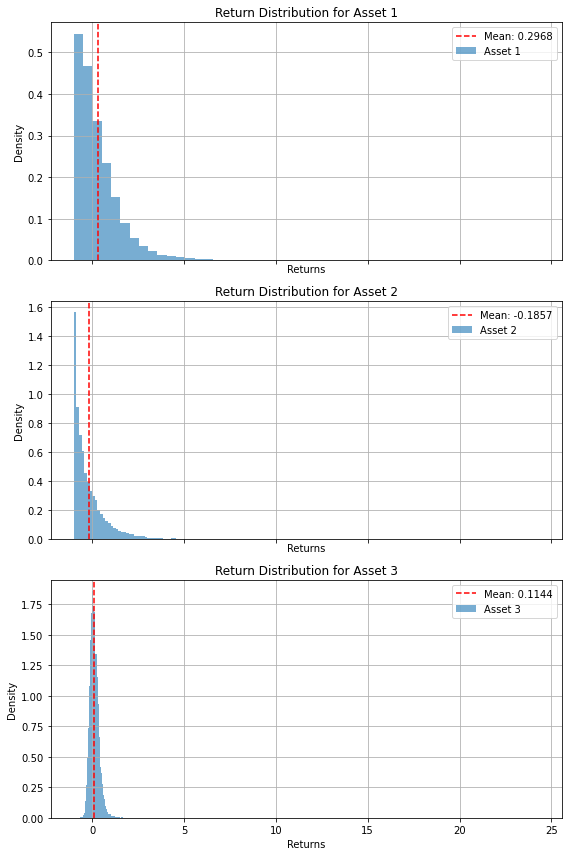

In [26]:
# Plot the return distribution for each asset with mean
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for i, ax in enumerate(axes):
    asset_data = data.iloc[:, i]
    mean_value = asset_data.mean()
    ax.hist(asset_data, bins=50, density=True, alpha=0.6, label=f"Asset {i+1}")
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {mean_value:.4f}")
    ax.set_title(f"Return Distribution for Asset {i+1}")
    ax.set_xlabel("Returns")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


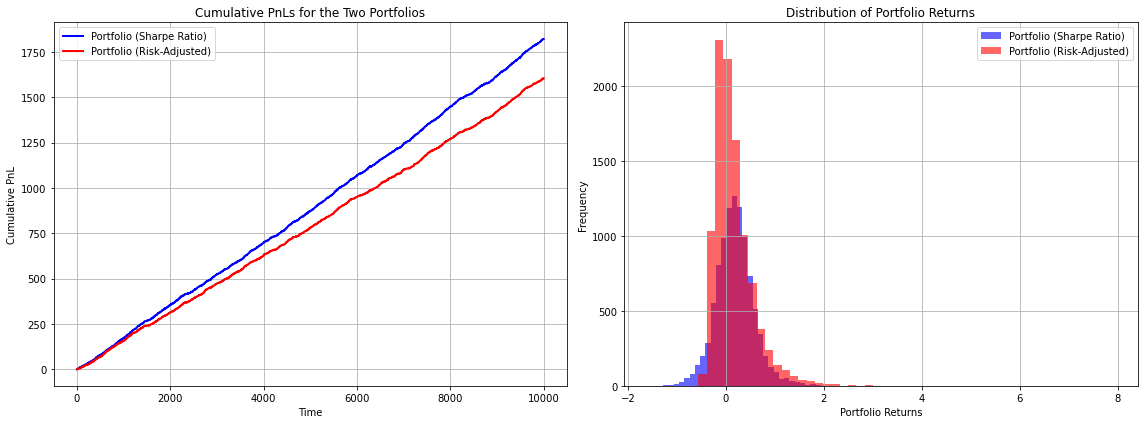

In [31]:
weights_sharpe_ratio = np.array([optimal_weights[0], optimal_weights[1], optimal_weights[2]])
weights_risk_adjusted = np.array([rrp_weights[0], rrp_weights[1], rrp_weights[2]])

portfolio_returns_sharpe = np.dot(data.values, weights_sharpe_ratio)
portfolio_returns_risk_adjusted = np.dot(data.values, weights_risk_adjusted)


cumulative_pnl_sharpe = np.cumsum(portfolio_returns_sharpe)
cumulative_pnl_risk_adjusted = np.cumsum(portfolio_returns_risk_adjusted)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(cumulative_pnl_sharpe, label="Portfolio (Sharpe Ratio)", linewidth=2, color='blue')
axes[0].plot(cumulative_pnl_risk_adjusted, label="Portfolio (Risk-Adjusted)", linewidth=2, color='red')
axes[0].set_title("Cumulative PnLs for the Two Portfolios")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Cumulative PnL")
axes[0].legend()
axes[0].grid(True)

axes[1].hist(portfolio_returns_sharpe, bins=50, alpha=0.6, label="Portfolio (Sharpe Ratio)", color='blue')
axes[1].hist(portfolio_returns_risk_adjusted, bins=50, alpha=0.6, label="Portfolio (Risk-Adjusted)", color='red')
axes[1].set_title("Distribution of Portfolio Returns")
axes[1].set_xlabel("Portfolio Returns")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


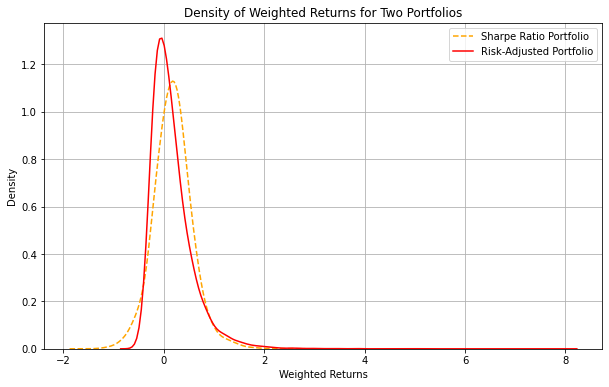

In [33]:
weighted_returns_sharpe = np.dot(data.values, weights_sharpe_ratio)
weighted_returns_risk_adjusted = np.dot(data.values, weights_risk_adjusted)
plt.figure(figsize=(10, 6))

sns.kdeplot(weighted_returns_sharpe, label="Sharpe Ratio Portfolio", bw_adjust=1.5, linestyle="--", color="orange")

sns.kdeplot(weighted_returns_risk_adjusted, label="Risk-Adjusted Portfolio", bw_adjust=1.5, color="red")

plt.title("Density of Weighted Returns for Two Portfolios")
plt.xlabel("Weighted Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


Sharpe Ratio Portfolio - Skewness: 0.4649, Kurtosis: 2.6224, ES (5%): 0.6272
Risk-Adjusted Portfolio - Skewness: 2.6904, Kurtosis: 20.8520, ES (5%): 0.3461


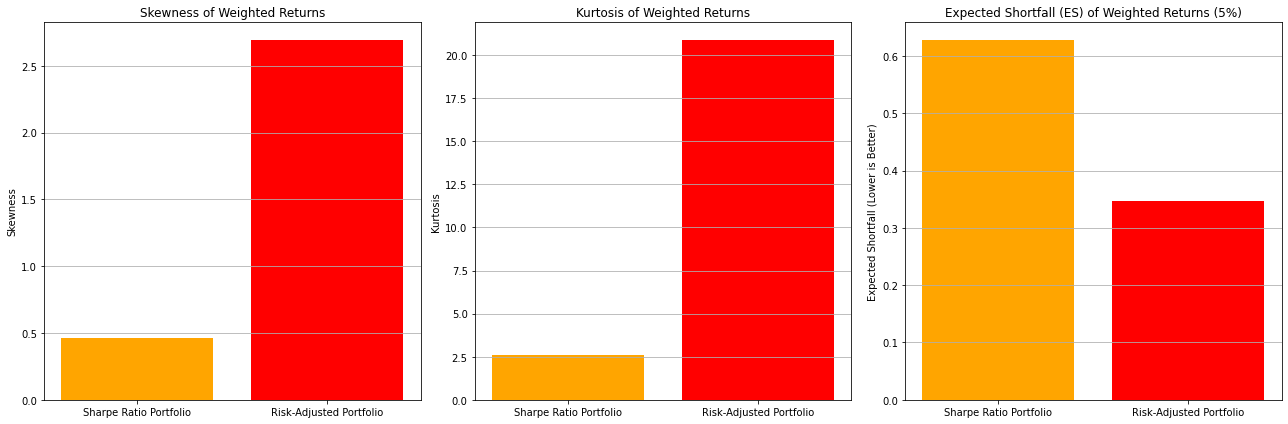

In [34]:
skewness_sharpe = skew(weighted_returns_sharpe)
skewness_risk_adjusted = skew(weighted_returns_risk_adjusted)

kurtosis_sharpe = kurtosis(weighted_returns_sharpe)
kurtosis_risk_adjusted = kurtosis(weighted_returns_risk_adjusted)

def calculate_es(returns, alpha=0.05):
    sorted_returns = np.sort(returns)
    threshold_index = int(np.floor(alpha * len(sorted_returns)))
    es_value = np.mean(sorted_returns[:threshold_index])
    return es_value

es_sharpe = -calculate_es(weighted_returns_sharpe, alpha=0.05)
es_risk_adjusted = -calculate_es(weighted_returns_risk_adjusted, alpha=0.05)

print(f"Sharpe Ratio Portfolio - Skewness: {skewness_sharpe:.4f}, Kurtosis: {kurtosis_sharpe:.4f}, ES (5%): {es_sharpe:.4f}")
print(f"Risk-Adjusted Portfolio - Skewness: {skewness_risk_adjusted:.4f}, Kurtosis: {kurtosis_risk_adjusted:.4f}, ES (5%): {es_risk_adjusted:.4f}")

labels = ['Sharpe Ratio Portfolio', 'Risk-Adjusted Portfolio']
skewness_values = [skewness_sharpe, skewness_risk_adjusted]
kurtosis_values = [kurtosis_sharpe, kurtosis_risk_adjusted]
es_values = [es_sharpe, es_risk_adjusted]
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(labels, skewness_values, color=['orange', 'red'])
plt.title("Skewness of Weighted Returns")
plt.ylabel("Skewness")
plt.grid(axis='y')

plt.subplot(1, 3, 2)
plt.bar(labels, kurtosis_values, color=['orange', 'red'])
plt.title("Kurtosis of Weighted Returns")
plt.ylabel("Kurtosis")
plt.grid(axis='y')

plt.subplot(1, 3, 3)
plt.bar(labels, es_values, color=['orange', 'red'])
plt.title("Expected Shortfall (ES) of Weighted Returns (5%)")
plt.ylabel("Expected Shortfall (Lower is Better)")
plt.grid(axis='y')

plt.tight_layout()
plt.show()
